# Intro

In [116]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from sklearn import metrics
from scipy import stats
from scipy.stats import norm

import catboost

%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

RANDOM_STATE = 42
TEST_SIZE = 0.25
N_THREADS = 4
N_FOLDS = 5
CV = 5
TIMEOUT = 300

import warnings

warnings.filterwarnings("ignore")

# Get DF

In [2]:
from catboost.datasets import amazon
(df_train, df_test) = amazon()
df_train[:5]

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
# change dtypes
cat_cols = [
    'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
    'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'
]

df_train[cat_cols] = df_train[cat_cols].astype('category')
df_test[cat_cols] = df_test[cat_cols].astype('category')

# Exploring data

In [4]:
print(df_train.info())
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ACTION            32769 non-null  int64   
 1   RESOURCE          32769 non-null  category
 2   MGR_ID            32769 non-null  category
 3   ROLE_ROLLUP_1     32769 non-null  category
 4   ROLE_ROLLUP_2     32769 non-null  category
 5   ROLE_DEPTNAME     32769 non-null  category
 6   ROLE_TITLE        32769 non-null  category
 7   ROLE_FAMILY_DESC  32769 non-null  category
 8   ROLE_FAMILY       32769 non-null  category
 9   ROLE_CODE         32769 non-null  category
dtypes: category(9), int64(1)
memory usage: 1.4 MB
None


,ACTION
count,32769.000
mean,0.942
std,0.234
min,0.000
25%,1.000
50%,1.000
75%,1.000
max,1.000


In [5]:
# # fast EDA
# profile = ProfileReport(df_train, title="Profiling Report")
# profile

# Exploring the data

In [6]:
# columns to drop
uniformative_cols = ['ROLE_FAMILY_DESC', 'ROLE_CODE']

df_train = df_train.drop(uniformative_cols, axis=1)
df_test = df_test.drop(uniformative_cols, axis=1)

In [7]:
# train/test split
y = df_train['ACTION']
X = df_train.drop(['ACTION'], axis=1)

In [8]:
cat_features = X.select_dtypes('category').columns.tolist()

# Split data into train and validation

In [9]:
# Import for classification problems
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, precision_recall_curve,
                             auc, roc_curve, recall_score)

from catboost import CatBoost, CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  train_size=0.8,
                                                  random_state=RANDOM_STATE)

print(X_train.shape)
print(X_val.shape)

(26215, 7)
(6554, 7)


# Modeling

loss_function:
- **Logloss** for binary
- **CrossEntropy** for probabilities in target

## Basic

In [11]:
clf = CatBoostClassifier(iterations=200, random_seed=RANDOM_STATE)
clf.fit(X_train, y_train, cat_features=cat_features, verbose=50)

Learning rate set to 0.181807
0:	learn: 0.5035093	total: 184ms	remaining: 36.6s
50:	learn: 0.1555438	total: 3.5s	remaining: 10.2s
100:	learn: 0.1461173	total: 7.04s	remaining: 6.9s
150:	learn: 0.1381416	total: 10.6s	remaining: 3.43s
199:	learn: 0.1322675	total: 14s	remaining: 0us


In [12]:
y_pred = clf.predict_proba(X_train)
y_pred

array([[0.01163288, 0.98836712],
       [0.00637887, 0.99362113],
       [0.26710615, 0.73289385],
       ...,
       [0.0032544 , 0.9967456 ],
       [0.01491893, 0.98508107],
       [0.02654743, 0.97345257]])

## Stdout of the training

In [13]:
clf = CatBoostClassifier(iterations=200,
                         learning_rate=0.15,
                         verbose=50,
                         random_seed=RANDOM_STATE)
clf.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

0:	learn: 0.5323045	test: 0.5321613	best: 0.5321613 (0)	total: 41.2ms	remaining: 8.2s
50:	learn: 0.1567473	test: 0.1393827	best: 0.1393827 (50)	total: 3.53s	remaining: 10.3s
100:	learn: 0.1485654	test: 0.1373369	best: 0.1372843 (94)	total: 7.23s	remaining: 7.08s
150:	learn: 0.1418426	test: 0.1373629	best: 0.1371569 (136)	total: 10.9s	remaining: 3.54s
199:	learn: 0.1355202	test: 0.1372052	best: 0.1368747 (166)	total: 14.7s	remaining: 0us

bestTest = 0.1368747452
bestIteration = 166

Shrink model to first 167 iterations.


**Commentary:**
- **LEARN**: learning error (will decrease all time)
- **TEST**: test error that at some point reverts (rises from certain point - shown on graph)
- **BEST**: goes to best iter and then stops (best is 194, then score do not improve)

In [14]:
clf = CatBoostClassifier(iterations=200,
                         learning_rate=0.15,
                         custom_loss=['AUC', 'Accuracy'],
                         random_seed=RANDOM_STATE)
clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=50,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5323045	test: 0.5321613	best: 0.5321613 (0)	total: 56.3ms	remaining: 11.2s
50:	learn: 0.1567473	test: 0.1393827	best: 0.1393827 (50)	total: 4.14s	remaining: 12.1s
100:	learn: 0.1485654	test: 0.1373369	best: 0.1372843 (94)	total: 7.99s	remaining: 7.83s
150:	learn: 0.1418426	test: 0.1373629	best: 0.1371569 (136)	total: 12.1s	remaining: 3.93s
199:	learn: 0.1355202	test: 0.1372052	best: 0.1368747 (166)	total: 16s	remaining: 0us

bestTest = 0.1368747452
bestIteration = 166

Shrink model to first 167 iterations.


## Model comparison

In [15]:
clf1 = CatBoostClassifier(iterations=200,
                          learning_rate=0.1,
                          train_dir='learning_rate_0.1',
                          random_seed=RANDOM_STATE)
clf2 = CatBoostClassifier(iterations=200,
                          learning_rate=0.01,
                          train_dir='learning_rate_0.01',
                          random_seed=RANDOM_STATE)

clf1.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=50)
clf2.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 49.3ms	remaining: 9.82s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 3.49s	remaining: 10.2s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 7.5s	remaining: 7.35s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 11.6s	remaining: 3.76s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 15.4s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 0.6811148	test: 0.6811187	best: 0.6811187 (0)	total: 59.8ms	remaining: 11.9s
50:	learn: 0.3448588	test: 0.3427953	best: 0.3427953 (50)	total: 2.5s	remaining: 7.3s
100:	learn: 0.2392987	test: 0.2334130	best: 0.2334130 (100)	total: 5.61s	remaining: 5.49s
150:	learn: 0.1968348	test: 0.1843852	best: 0.1843852 (150)	total: 9.01s	remaining: 2.92s
199:	learn: 0.1818363	test: 0.1653072	best: 0.1653072 (199)	total: 12.4s	remaining: 0us

bestTest = 0.1653071964
bestIter

In [16]:
# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def eval_metrics(model):
    # Make predictions on the validation set for the first model
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics for the first model
    accuracy = round(accuracy_score(y_val, y_pred), 4)
    precision = round(precision_score(y_val, y_pred), 4)
    recall = round(recall_score(y_val, y_pred), 4)
    f1 = round(f1_score(y_val, y_pred), 4)

    # Print the evaluation metrics for the first model
    print("Evaluation metrics:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()


eval_metrics(clf1)
eval_metrics(clf2)

Evaluation metrics:
Accuracy: 0.9556
Precision: 0.965
Recall: 0.9888
F1 Score: 0.9768

Evaluation metrics:
Accuracy: 0.9466
Precision: 0.9477
Recall: 0.9985
F1 Score: 0.9724



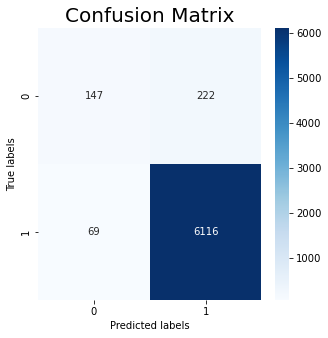

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.40      0.50       369
           1       0.96      0.99      0.98      6185

    accuracy                           0.96      6554
   macro avg       0.82      0.69      0.74      6554
weighted avg       0.95      0.96      0.95      6554

----------------------------------------------------------------------------------------------------


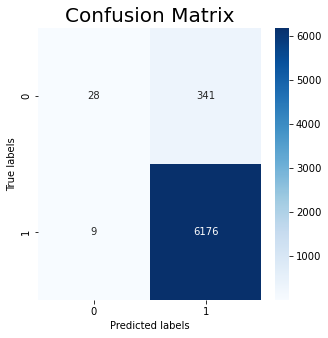

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.08      0.14       369
           1       0.95      1.00      0.97      6185

    accuracy                           0.95      6554
   macro avg       0.85      0.54      0.56      6554
weighted avg       0.94      0.95      0.93      6554

----------------------------------------------------------------------------------------------------


In [75]:
# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

def eval_reports(model):
    # Make predictions on the validation set for the first model
    y_pred = model.predict(X_val)

    # Строим матрицу ошибок
    cm = confusion_matrix(y_val, model.predict(X_val))

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    # Classification report
    cr = classification_report(y_val, y_pred)
    
    print(f"Classification Report:")
    print(cr)
    print('-'*100)

eval_reports(clf1)
eval_reports(clf2)

## Best iteration / Custom loss

In [18]:
params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'learning_rate': 0.1,
    'random_seed': RANDOM_STATE
}

clf = CatBoostClassifier(**params)
clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 55.4ms	remaining: 11s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 4.04s	remaining: 11.8s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 8.77s	remaining: 8.6s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 13.4s	remaining: 4.34s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 17.9s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.


In [19]:
print("Best score:", clf.best_score_)
print("Params:",clf.get_params())
print("Best iteration:", clf.best_iteration_)
print("Total trees:",  clf.tree_count_)

Best score: {'learn': {'Logloss': 0.1457817274364799}, 'validation': {'Logloss': 0.13702666527897264}}
Params: {'iterations': 200, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 42}
Best iteration: 196
Total trees: 197


In [20]:
params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'learning_rate': 0.1,
    'custom_loss': 'AUC',
    'random_seed': RANDOM_STATE
}

clf = CatBoostClassifier(**params)
clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 79.8ms	remaining: 15.9s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 4.48s	remaining: 13.1s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 9.42s	remaining: 9.23s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 14.6s	remaining: 4.75s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 19.6s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.


In [21]:
print("Best score:", clf.best_score_)
print("Params:",clf.get_params())
print("Best iteration:", clf.best_iteration_)
print("Total trees:",  clf.tree_count_)

Best score: {'learn': {'Logloss': 0.1457817274364799}, 'validation': {'Logloss': 0.13702666527897264, 'AUC': 0.8928982830652882}}
Params: {'iterations': 200, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 42, 'custom_loss': 'AUC'}
Best iteration: 196
Total trees: 197


## Pool

There are several ways of passing dataset to training using X,y (the initial matrix) or using Pool class. Pool class is the class for storing the dataset.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [22]:
from catboost import Pool

train_pool = Pool(data=X, label=y, cat_features=cat_features, has_header=True)
eval_pool = Pool(data=X_val, label=y_val, cat_features=cat_features, has_header=True)
test_pool = Pool(df_test, cat_features=cat_features, has_header=True)

## Cross validation with catboost

The following parameters describe how to split the dataset for cross validation:

- **stratified** (True / False)
- **folds** (stratified_shuffle_split / shuffle_split / repeated_split / custom iterator)
- **type** (Classical / Inverted / TimeSeries)

In [23]:
from catboost import cv

N_FOLDS = 2  # Для визуализации

params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'learning_rate': 0.1,
    'custom_loss': 'AUC',
    'random_seed': RANDOM_STATE
}

def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

### Not stratified

In [24]:
cv_data = cv(params=params,
             pool=train_pool,
             fold_count=N_FOLDS,
             shuffle=True,
             partition_random_seed=0,
             stratified=False,
             verbose=False)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1757186671
bestIteration = 99

Training on fold [1/2]

bestTest = 0.1625033257
bestIteration = 99

Best validation Logloss score : 0.1691±0.0093 on step 99


### Stratified

Stratified cross validation makes sense only for classification. If stratified=True, each fold contains the same percent of rows of each class as the dataset. If stratified=False, folds are sampled uniformly.

Usually, stratified cross validation has smaller standard deviation of loss value.

In [25]:
cv_data = cv(params=params,
             pool=train_pool,
             fold_count=N_FOLDS,
             shuffle=True,
             partition_random_seed=0,
             stratified=True,
             verbose=False)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1696693094
bestIteration = 99

Training on fold [1/2]

bestTest = 0.1704956575
bestIteration = 97

Best validation Logloss score : 0.1701±0.0006 on step 99


## Types of CatBoost folds

If type='Classical', then each test set consists of a single fold, and the corresponding train set consists of the remaining k-1 folds.

In [26]:
cv_data = cv(params=params,
             pool=train_pool,
             fold_count=N_FOLDS,
             shuffle=True,
#              plot=True,
             type='Classical',
             verbose=False)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1696693094
bestIteration = 99

Training on fold [1/2]

bestTest = 0.1704956575
bestIteration = 97

Best validation Logloss score : 0.1701±0.0006 on step 99


If type='Inverted', then each test set consists of k-1 folds, and the corresponding train set consists of the remaining fold.

In [27]:
cv_data = cv(params=params,
             pool=train_pool,
             fold_count=N_FOLDS,
             shuffle=True,
#              plot=True,
             type='Inverted',
             verbose=False)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1704956575
bestIteration = 97

Training on fold [1/2]

bestTest = 0.1696693094
bestIteration = 99

Best validation Logloss score : 0.1701±0.0006 on step 99


If type=TimeSeries, then each train set consists of the first k folds, and the corresponding test set consists of the (k+1)-th fold.

Usually, this type of folds reduces standard deviation of loss value, if order of rows in the dataset is important.

In [28]:
# cv_data = cv(params=params,
#              pool=train_pool,
#              fold_count=5,
#              shuffle=True,
#              plot=True,
#              type='TimeSeries',
#              verbose=False)

# print_cv_summary(cv_data)

## Cross validation with sklearn folds

### Random permutation cross-validator

In [29]:
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(n_splits=N_FOLDS,
                             test_size=TEST_SIZE,
                             random_state=RANDOM_STATE)
cv_data = cv(
    params=params,
    pool=train_pool,
    verbose=False,
#     plot=True,
    folds=shuffle_split)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1607512613
bestIteration = 99

Training on fold [1/2]

bestTest = 0.1606223277
bestIteration = 96

Best validation Logloss score : 0.1607±0.0001 on step 98


### Repeated K-Fold cross validator

In [30]:
from sklearn.model_selection import RepeatedKFold

repeated_split = RepeatedKFold(n_splits=N_FOLDS,
                               n_repeats=2,
                               random_state=RANDOM_STATE)
cv_data = cv(
    params=params,
    pool=train_pool,
    verbose=False,
#     plot=True,
    folds=repeated_split)

print_cv_summary(cv_data)

Training on fold [0/4]

bestTest = 0.1656849772
bestIteration = 99

Training on fold [1/4]

bestTest = 0.1743546954
bestIteration = 98

Training on fold [2/4]

bestTest = 0.1703305185
bestIteration = 85

Training on fold [3/4]

bestTest = 0.1668982474
bestIteration = 99

Best validation Logloss score : 0.1693±0.0039 on step 99


### Stratified ShuffleSplit cross-validator

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_shuffle_split = StratifiedShuffleSplit(n_splits=N_FOLDS,
                                                  test_size=TEST_SIZE,
                                                  random_state=RANDOM_STATE)
cv_data = cv(params=params,
             pool=train_pool,
             verbose=False,
#              plot=True,
             folds=stratified_shuffle_split)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1659885249
bestIteration = 92

Training on fold [1/2]

bestTest = 0.1629630002
bestIteration = 97

Best validation Logloss score : 0.1646±0.0022 on step 96


### K-Fold

In [32]:
from sklearn.model_selection import KFold

basic_split = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

cv_data = cv(params=params,
             pool=train_pool,
             verbose=False,
#              plot=True,
             folds=basic_split)

print_cv_summary(cv_data)

Training on fold [0/2]

bestTest = 0.1656849772
bestIteration = 99

Training on fold [1/2]

bestTest = 0.1743546954
bestIteration = 98

Best validation Logloss score : 0.1700±0.0061 on step 99


## Overfitting detector

In [33]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 20
}

clf = CatBoostClassifier(**params)

clf.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
#     plot=True,
    verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 61.2ms	remaining: 30.5s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 4.9s	remaining: 43.1s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 10.3s	remaining: 40.7s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 16.6s	remaining: 38.4s
200:	learn: 0.1457496	test: 0.1370325	best: 0.1370267 (196)	total: 21.9s	remaining: 32.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1370180423
bestIteration = 201

Shrink model to first 202 iterations.


In [34]:
print(clf.tree_count_)
print(clf.best_score_)

202
{'learn': {'Logloss': 0.14382863104729943}, 'validation': {'Logloss': 0.13701804225838768}}


In [35]:
params = {
    'eval_metric': 'AUC',
    'iterations': 500,
    'learning_rate': 0.1,
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 20
}

clf = CatBoostClassifier(**params)

clf.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
#     plot=True,
    verbose=50)

0:	test: 0.5124265	best: 0.5124265 (0)	total: 65.4ms	remaining: 32.6s
50:	test: 0.8845156	best: 0.8845156 (50)	total: 5.31s	remaining: 46.7s
100:	test: 0.8879490	best: 0.8879490 (100)	total: 11.1s	remaining: 44s
150:	test: 0.8911640	best: 0.8911640 (150)	total: 16.9s	remaining: 39.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8921748789
bestIteration = 163

Shrink model to first 164 iterations.


In [36]:
print(clf.tree_count_)
print(clf.best_score_)

164
{'learn': {'Logloss': 0.14729165420045187}, 'validation': {'Logloss': 0.13720836706006653, 'AUC': 0.8921748789031948}}


## Select decision boundary

In [77]:
params = {'iterations': 200, 'random_seed': RANDOM_STATE, 'learning_rate': 0.1}

clf = CatBoostClassifier(**params)

clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 133ms	remaining: 26.5s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 7.61s	remaining: 22.2s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 15.6s	remaining: 15.3s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 24.1s	remaining: 7.83s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 32.7s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.


In [80]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

curve = get_roc_curve(clf, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

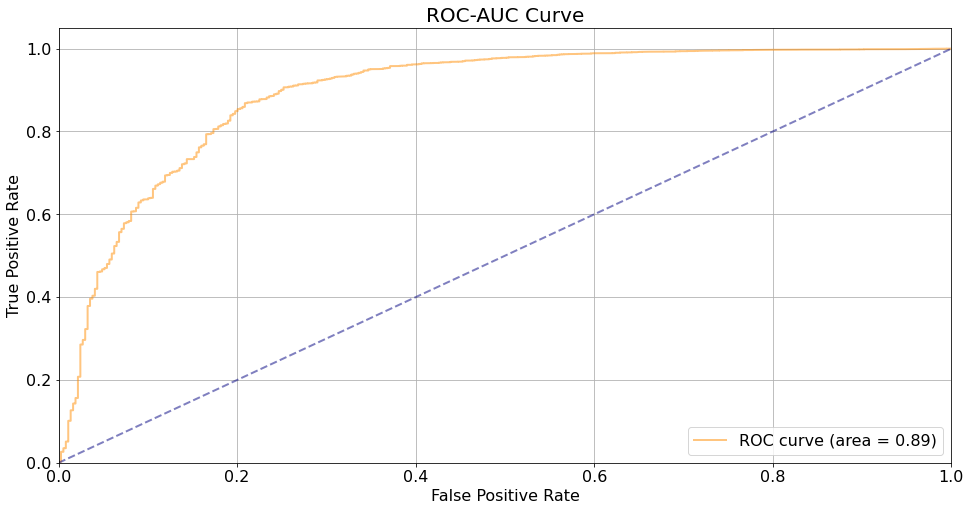

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr,
         tpr,
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc,
         alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [40]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

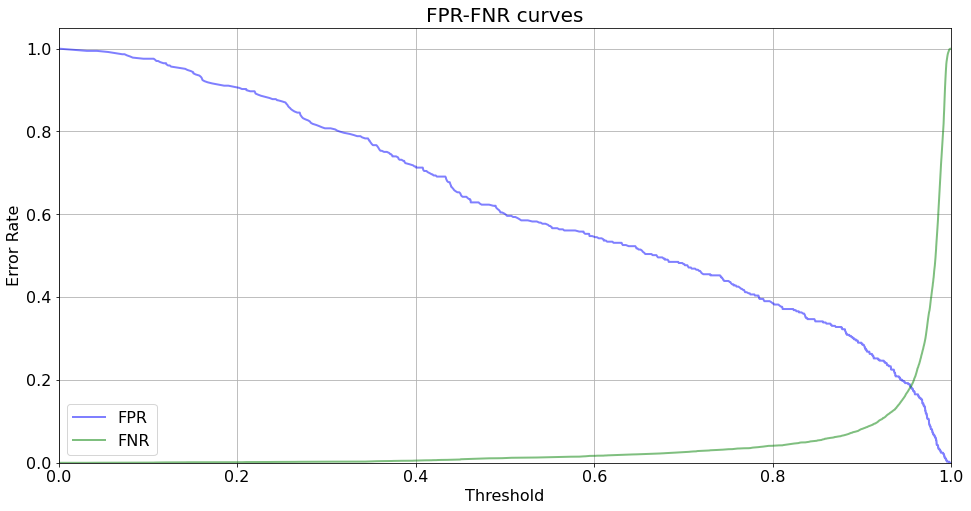

In [41]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [42]:
from catboost.utils import select_threshold

print(round(select_threshold(model=clf, data=eval_pool, FNR=0.01), 4))
print(round(select_threshold(model=clf, data=eval_pool, FPR=0.01), 4))

0.4698
0.9939


## Model predictions

In [43]:
clf.predict_proba(X_val)

array([[0.00990121, 0.99009879],
       [0.01635136, 0.98364864],
       [0.02315953, 0.97684047],
       ...,
       [0.01460598, 0.98539402],
       [0.00647202, 0.99352798],
       [0.01361547, 0.98638453]])

In [44]:
clf.predict(X_val)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [45]:
raw_pred = clf.predict(data=X_val, prediction_type='RawFormulaVal')
print(raw_pred)

[4.60514732 4.09695787 3.74191695 ... 4.21161052 5.03377411 4.28283936]


In [46]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.99009879 0.98364864 0.97684047 ... 0.98539402 0.99352798 0.98638453]


## Metric evaluation on a new dataset

In [47]:
params = {
    'iterations': 200,
    'random_seed': RANDOM_STATE,
    'learning_rate': 0.1,
    'early_stopping_rounds': 20
}

clf = CatBoostClassifier(**params)

clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 70.5ms	remaining: 14s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 5.71s	remaining: 16.7s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 11.9s	remaining: 11.7s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 18.2s	remaining: 5.92s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 24.5s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.


In [48]:
metrics =  clf.eval_metrics(data=train_pool,
                 metrics=['Logloss', 'AUC'],
                 ntree_start=0,
                 ntree_end=0,
                 eval_period=1
                )

print('AUC values:')
print(np.array(metrics['AUC']))
print()
print(np.array(metrics['AUC']).mean())

AUC values:
[0.51606922 0.5964047  0.6058886  0.60589464 0.60589464 0.74694422
 0.74906769 0.75899744 0.79703895 0.850107   0.88553578 0.90098702
 0.91013263 0.91921487 0.92624009 0.92820527 0.92856    0.92902381
 0.92926004 0.92924489 0.9347724  0.93515772 0.94480516 0.95145857
 0.95645854 0.96053817 0.9627126  0.96338102 0.9642124  0.96632087
 0.96642259 0.966595   0.96750224 0.96739614 0.96771058 0.96761887
 0.96856014 0.96874696 0.96893533 0.96890576 0.96889915 0.96922434
 0.96905297 0.96969489 0.96987989 0.97008943 0.96991642 0.96976892
 0.96983682 0.9703511  0.97044012 0.97067215 0.97067315 0.97076447
 0.97088953 0.97080506 0.9708039  0.97086781 0.97112686 0.97112182
 0.97120137 0.97115121 0.97121865 0.97114901 0.97110689 0.97123531
 0.97124405 0.97129992 0.97135545 0.97156811 0.97150891 0.9727244
 0.97282359 0.97393158 0.97396429 0.97396523 0.97395386 0.97395683
 0.97408981 0.97499687 0.97502195 0.97519177 0.97532658 0.97593253
 0.97592818 0.97595142 0.97616307 0.97616307 0.9761

## Feature importances

In [49]:
params = {
    'iterations': 200,
    'random_seed': RANDOM_STATE,
    'learning_rate': 0.1,
    'early_stopping_rounds': 20
}

clf = CatBoostClassifier(**params)

clf.fit(X_train,
        y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=50)

0:	learn: 0.5812761	test: 0.5812277	best: 0.5812277 (0)	total: 79.6ms	remaining: 15.8s
50:	learn: 0.1624291	test: 0.1416053	best: 0.1416053 (50)	total: 6.02s	remaining: 17.6s
100:	learn: 0.1550260	test: 0.1387065	best: 0.1387065 (100)	total: 12.9s	remaining: 12.6s
150:	learn: 0.1502514	test: 0.1376356	best: 0.1376356 (150)	total: 19.6s	remaining: 6.36s
199:	learn: 0.1457817	test: 0.1370687	best: 0.1370267 (196)	total: 26.2s	remaining: 0us

bestTest = 0.1370266653
bestIteration = 196

Shrink model to first 197 iterations.


In [50]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.011
1,MGR_ID,19.893
2,ROLE_DEPTNAME,15.637
3,ROLE_TITLE,15.397
4,ROLE_ROLLUP_2,12.557
5,ROLE_FAMILY,7.792
6,ROLE_ROLLUP_1,6.713


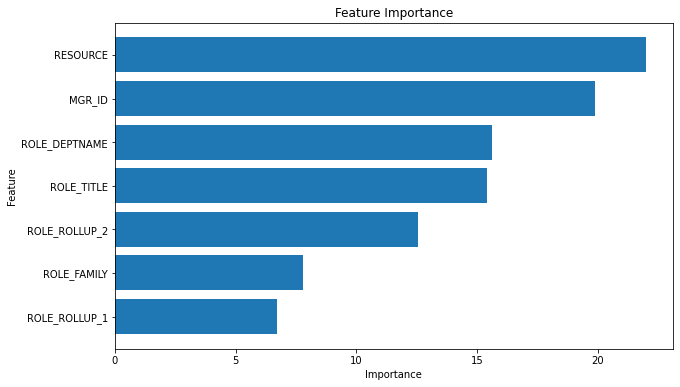

In [51]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = clf.get_feature_importance(prettified=True)

# Extract feature names and importance values
features = feature_importance['Feature Id']
importance = feature_importance['Importances']

# Sort features based on importance values
sorted_indices = np.argsort(importance)
sorted_features = features[sorted_indices]
sorted_importance = importance[sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

## Hyperparameter tunning

### Simple grid search

In [52]:
clf = CatBoostClassifier(iterations=100, verbose=50)

grid = {
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

grid_search_results = clf.grid_search(grid,
                                      train_pool,
                                      shuffle=False,
#                                       plot=True,
                                      verbose=50)

0:	learn: 0.6810327	test: 0.6811037	best: 0.6811037 (0)	total: 69.2ms	remaining: 6.85s
50:	learn: 0.3434502	test: 0.3452252	best: 0.3452252 (50)	total: 4.12s	remaining: 3.96s
99:	learn: 0.2490708	test: 0.2507729	best: 0.2507729 (99)	total: 8.56s	remaining: 0us

bestTest = 0.2507729098
bestIteration = 99

0:	loss: 0.2507729	best: 0.2507729 (0)	total: 8.64s	remaining: 3m 18s
0:	learn: 0.5805328	test: 0.5812428	best: 0.5812428 (0)	total: 71.8ms	remaining: 7.1s
50:	learn: 0.1770639	test: 0.1651905	best: 0.1651905 (50)	total: 4.8s	remaining: 4.61s
99:	learn: 0.1730723	test: 0.1613972	best: 0.1613972 (99)	total: 9.36s	remaining: 0us

bestTest = 0.1613972104
bestIteration = 99

0:	learn: 0.6808566	test: 0.6809287	best: 0.6809287 (0)	total: 80.2ms	remaining: 7.94s
50:	learn: 0.3438555	test: 0.3457479	best: 0.3457479 (50)	total: 4.46s	remaining: 4.29s
99:	learn: 0.2499693	test: 0.2515821	best: 0.2515821 (99)	total: 8.88s	remaining: 0us

bestTest = 0.2515820899
bestIteration = 99

0:	learn: 0.57

50:	learn: 0.1606352	test: 0.1641511	best: 0.1641511 (50)	total: 10.9s	remaining: 10.5s
99:	learn: 0.1438142	test: 0.1624688	best: 0.1623878 (98)	total: 23s	remaining: 0us

bestTest = 0.1623878052
bestIteration = 98



In [53]:
grid_search_results['params']

{'depth': 10, 'l2_leaf_reg': 5, 'learning_rate': 0.1}

In [54]:
grid_search_results['cv_results'].keys()

dict_keys(['iterations', 'test-Logloss-mean', 'test-Logloss-std', 'train-Logloss-mean', 'train-Logloss-std'])

In [55]:
grid_search_results['cv_results']['test-Logloss-mean'][-1]

0.1626654962224192

In [56]:
predicted = clf.predict_proba(test_pool)
predicted[:3]

array([[0.1693764 , 0.8306236 ],
       [0.03329067, 0.96670933],
       [0.01095847, 0.98904153]])

### Searching over several grids

In [57]:
clf = CatBoostClassifier(iterations=100, verbose=50)

grid_1 = {
    'learning_rate': [0.03, 0.1, 0.3],
    'bootstrap_type': ['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
grid_2 = {
    'learning_rate': [0.03, 0.1, 0.3],
    'bootstrap_type': ['Bernoulli'],
    'subsample': [0.66, 0.7, 0.8]
}
grid_search_results = clf.grid_search([grid_1, grid_2],
                                      train_pool,
                                      shuffle=False,
#                                       plot=True,
                                      verbose=50)

Grid #0
0:	learn: 0.6563178	test: 0.6565509	best: 0.6565509 (0)	total: 104ms	remaining: 10.3s
50:	learn: 0.2046034	test: 0.2013099	best: 0.2013099 (50)	total: 5.07s	remaining: 4.87s
99:	learn: 0.1791653	test: 0.1706914	best: 0.1706914 (99)	total: 10s	remaining: 0us

bestTest = 0.1706914045
bestIteration = 99

0:	loss: 0.1706914	best: 0.1706914 (0)	total: 10.1s	remaining: 1m 21s
0:	learn: 0.5774178	test: 0.5781613	best: 0.5781613 (0)	total: 98ms	remaining: 9.7s
50:	learn: 0.1730631	test: 0.1629668	best: 0.1629668 (50)	total: 5.02s	remaining: 4.82s
99:	learn: 0.1672458	test: 0.1605058	best: 0.1605058 (99)	total: 9.93s	remaining: 0us

bestTest = 0.1605057575
bestIteration = 99

0:	learn: 0.4039658	test: 0.4059572	best: 0.4059572 (0)	total: 93.6ms	remaining: 9.26s
50:	learn: 0.1639597	test: 0.1599368	best: 0.1599368 (50)	total: 5.29s	remaining: 5.09s
99:	learn: 0.1531050	test: 0.1600545	best: 0.1592247 (84)	total: 10.3s	remaining: 0us

bestTest = 0.1592247214
bestIteration = 84

0:	learn: 

In [58]:
grid_search_results['params']

{'subsample': 0.8, 'learning_rate': 0.3, 'bootstrap_type': 'Bernoulli'}

### RandomizedSearchCV

In [92]:
# Define the CatBoost classifier
clf = CatBoostClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
clf_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'random_seed': [RANDOM_STATE],
    'cat_features': [cat_features],
    'verbose': [50]
}

# Define the KFold cross-validation
CV = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Perform RandomizedSearchCV with CatBoost and KFold
random_search = RandomizedSearchCV(estimator=clf,
                                   param_distributions=clf_params,
                                   cv=CV,
                                   n_iter=10,
                                   random_state=RANDOM_STATE)
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print()
print("Best Score: ", random_search.best_score_)

0:	learn: 0.5812371	total: 113ms	remaining: 33.9s
50:	learn: 0.1690688	total: 7.73s	remaining: 37.7s
100:	learn: 0.1574758	total: 20s	remaining: 39.4s
150:	learn: 0.1492778	total: 34.5s	remaining: 34.1s
200:	learn: 0.1423887	total: 47.2s	remaining: 23.2s
250:	learn: 0.1351723	total: 55.8s	remaining: 10.9s
299:	learn: 0.1283284	total: 1m 4s	remaining: 0us
0:	learn: 0.5794341	total: 127ms	remaining: 37.8s
50:	learn: 0.1568968	total: 6.69s	remaining: 32.7s
100:	learn: 0.1482116	total: 13.7s	remaining: 27.1s
150:	learn: 0.1419769	total: 18.3s	remaining: 18.1s
200:	learn: 0.1345261	total: 24.6s	remaining: 12.1s
250:	learn: 0.1275367	total: 30.5s	remaining: 5.96s
299:	learn: 0.1210617	total: 35.7s	remaining: 0us
0:	learn: 0.6854349	total: 35.2ms	remaining: 3.48s
50:	learn: 0.4346320	total: 2.12s	remaining: 2.03s
99:	learn: 0.3237677	total: 4.45s	remaining: 0us
0:	learn: 0.6853037	total: 42.4ms	remaining: 4.19s
50:	learn: 0.4303986	total: 2.48s	remaining: 2.38s
99:	learn: 0.3175937	total: 4.9

In [94]:
# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print()
print("Best Score: ", random_search.best_score_)

Best Parameters:  {'verbose': 50, 'random_seed': 42, 'loss_function': 'CrossEntropy', 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 3, 'cat_features': ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY']}

Best Score:  0.9491897298971763


In [113]:
clf = CatBoostClassifier(**random_search.best_params_)
clf.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
)

0:	learn: 0.5796821	test: 0.5797565	best: 0.5797565 (0)	total: 66.4ms	remaining: 19.9s
50:	learn: 0.1693799	test: 0.1466223	best: 0.1466223 (50)	total: 3.97s	remaining: 19.4s
100:	learn: 0.1644594	test: 0.1434629	best: 0.1434629 (100)	total: 7.9s	remaining: 15.6s
150:	learn: 0.1622003	test: 0.1422601	best: 0.1422601 (150)	total: 11.8s	remaining: 11.7s
200:	learn: 0.1603039	test: 0.1401785	best: 0.1401785 (200)	total: 15.6s	remaining: 7.68s
250:	learn: 0.1591184	test: 0.1396396	best: 0.1396396 (250)	total: 19.5s	remaining: 3.81s
299:	learn: 0.1579415	test: 0.1391747	best: 0.1391446 (296)	total: 23.3s	remaining: 0us

bestTest = 0.1391446078
bestIteration = 296

Shrink model to first 297 iterations.


In [114]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MGR_ID,24.908
1,RESOURCE,24.388
2,ROLE_TITLE,19.234
3,ROLE_DEPTNAME,12.517
4,ROLE_ROLLUP_2,9.563
5,ROLE_FAMILY,5.035
6,ROLE_ROLLUP_1,4.355


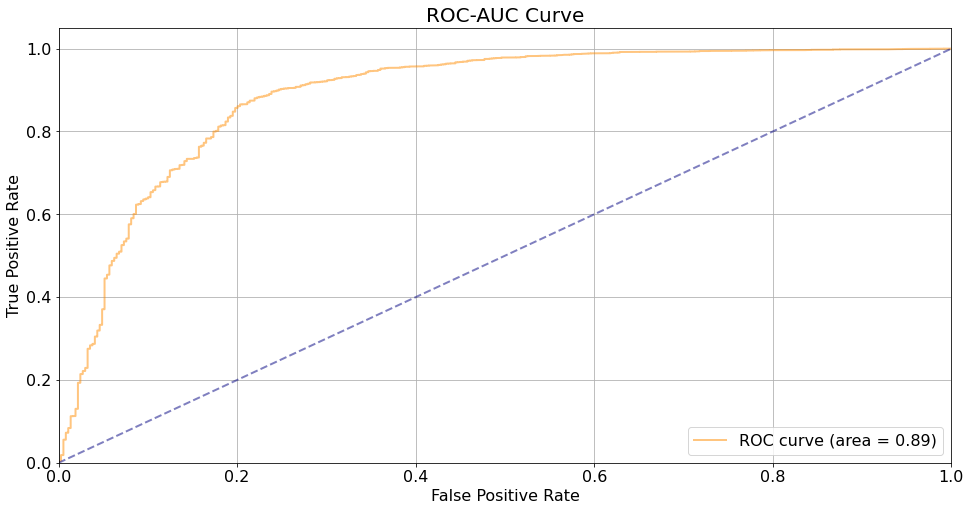

In [115]:
curve = get_roc_curve(clf, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr,
         tpr,
         color='darkorange',
         lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc,
         alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-AUC Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()